In [1]:
import scipy.io
import mne
import os
import numpy as np

mne.set_log_level('error')


In [2]:
# Dataset:
# https://osf.io/4dwjt/?view_only=d23acfd50655427fbaae381a17cbfbcc
data_root = 'C:/Data/UHD_EEG/'

In [9]:
subjects = ['S1', 'S2', 'S3', 'S4', 'S5']
dominant_hand = ['left','right','right','right','right']
mapping = {0: "No instruction", 1: "Rest", 2: "thumb", 3: "index", 4: "middle", 5: "ring", 6: "little"}
not_ROI_channels = ['c255', 'c256', 'c254', 'c251', 'c239', 'c240', 'c238', 'c235', 'c224', 'c222', 'c223', 'c219', 'c220', 'c221', 'c215', 'c216', 'c217', 'c213', 'c212', 'c211', 'c210', 'c209', 'c112', 'c110', 'c107', 'c108', 'c103', 'c104', 'c105', 'c101', 'c100', 'c99', 'c98', 'c97', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c14', 'c15', 'c16', 'c23', 'c29', 'c26', 'c17', 'c18', 'c20', 'c19', 'c21', 'c24', 'c22', 'c25', 'c28', 'c33', 'c35', 'c38', 'c42', 'c81', 'c34', 'c37', 'c41', 'c45', 'c36', 'c40', 'c44', 'c39', 'c43', 'c145', 'c147', 'c150', 'c154', 'c157', 'c153', 'c149', 'c146', 'c93', 'c159', 'c156', 'c152', 'c148', 'c95', 'c160', 'c158', 'c155', 'c151', 'c96', 'c202', 'c198', 'c195', 'c193']


In [4]:
def get_montage(hemishpere):
    mat = scipy.io.loadmat(os.path.join(data_root, 'montage', f'montage_256_{hemishpere}_hemisphere.mat'))
    return mat['pos_256']

left_handed_montage = get_montage('right')
right_handed_montage = get_montage('left')

In [5]:
def load_run(subject_id, run, describe=True):
    subject = subjects[subject_id]
    mat = scipy.io.loadmat(os.path.join(data_root, 'rawdata', subject, run))
    data = mat['y'][1:]  # remove timestamp
    ch_names = [f'c{i}' for i in range(1, 257)] + ['STIM']
    info = mne.create_info(ch_names=ch_names, sfreq=mat['SR\x00'][0][0])

    raw = mne.io.RawArray(data, info)
    ch_types = {ch: 'eeg' if ch != 'STIM' else 'stim' for ch in ch_names}
    raw.set_channel_types(ch_types)

    events = mne.find_events(raw, stim_channel='STIM')
    annot_from_events = mne.annotations_from_events(events, event_desc=mapping, sfreq=raw.info['sfreq'])
    raw.set_annotations(annot_from_events)
    raw.drop_channels(['STIM'])

    montage_positions = left_handed_montage if dominant_hand[subject_id] == 'left' else right_handed_montage
    montage = mne.channels.make_dig_montage(ch_pos=dict(zip(ch_names, montage_positions)), coord_frame='head')
    raw.set_montage(montage)

    if describe:
        raw.describe()
    return raw


In [7]:
demo = load_run(0, 'S1_run1.mat', describe=False)

In [10]:
demo.drop_channels(not_ROI_channels)

<RawArray | 158 x 135559 (225.9 s), ~163.6 MB, data loaded>

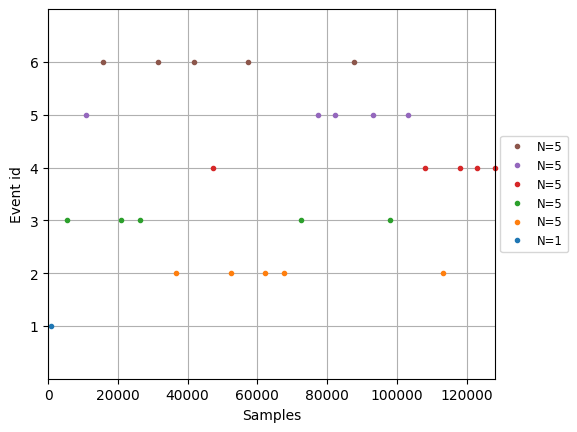

In [11]:
events, event_ids = mne.events_from_annotations(demo)
mne.viz.plot_events(events);

In [12]:
demo.filter(13., 25.)
demo.set_eeg_reference('average', projection=False)

# my_ids = [115,127,182,140,130,76,113]
# filt = ['c' + str(i) for i in my_ids]
# demo.pick_channels(filt)

<RawArray | 158 x 135559 (225.9 s), ~163.6 MB, data loaded>

In [13]:
epochs = mne.Epochs(demo, events, baseline = None, event_id= event_ids, tmin=-0.5, tmax=7, preload=True)

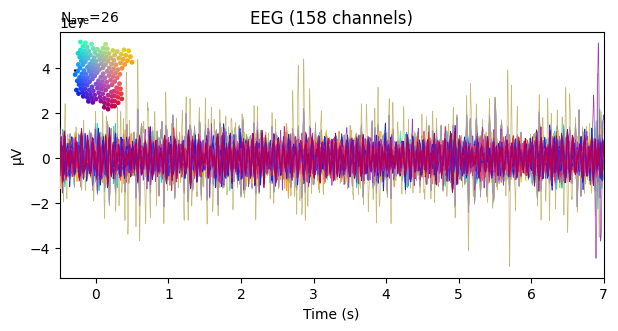

In [14]:
epochs.average().plot(spatial_colors=True);

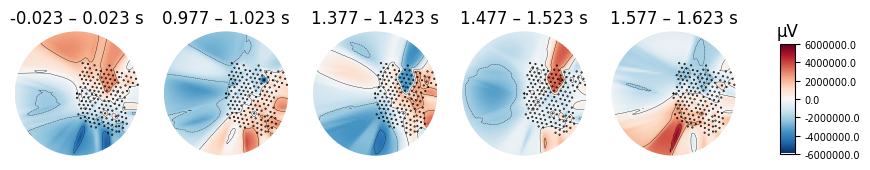

In [15]:
# Specify times to plot at, as [min],[max],[stepsize]
times = [0, 1., 1.4, 1.5, 1.6]

epochs.average().plot_topomap(times=times, average=0.050);

In [16]:
conditions = ['ring', 'middle']

evokeds = {c:epochs[c].average() for c in conditions}
for key in evokeds.keys():
  print(key,'-->',evokeds[key])  

ring --> <Evoked | 'ring' (average, N=5), -0.5 – 7 sec, baseline off, 158 ch, ~5.6 MB>
middle --> <Evoked | 'middle' (average, N=5), -0.5 – 7 sec, baseline off, 158 ch, ~5.6 MB>


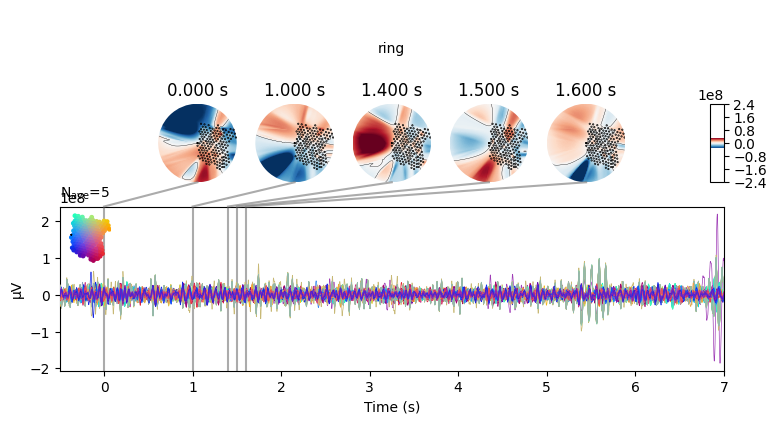

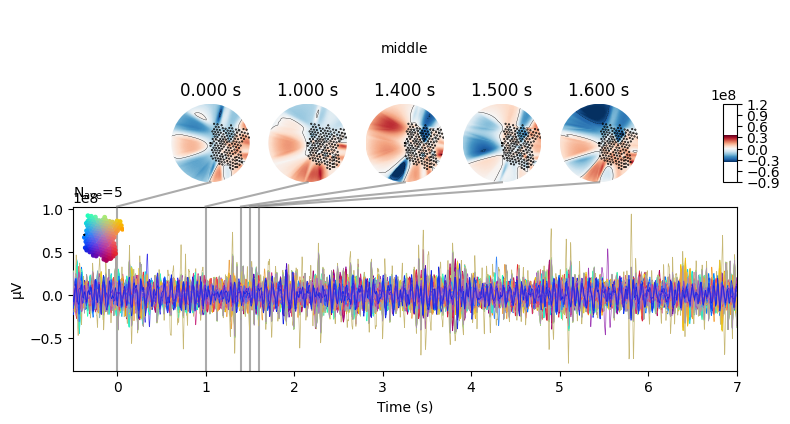

In [17]:
for c in evokeds.keys():
    evokeds[c].plot_joint(times=times, title=c);